In [10]:
# Selecting libraries
import yfinance as yf
import pandas as pd
import numpy as np
import pyfolio as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")
import re
import cvxopt as opt
from cvxopt import blas, solvers
pd.set_option('display.max_columns', 500)

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, objective_functions
from pypfopt import expected_returns

## What happened here
In this script we tested how we could use forecasted covariance matrices to build portfolios
Issues:
+ we took the square root of the variance, when it should be the square.
+ We took the monthly variance, but the mean value we used in the efficeint frontier was daily returns.
+ I also noted that risk_models.samplecovariance spits out annulaised daily returns always
+ The input volatility data was annulaised daily variance. we get this by multilplying by $ var * \sqrt{252} $
+ we then converted this to monthly by: $ var *(\sqrt{21} / \sqrt{252}) $
+ We had issues whereby the matrix forecasted is not PSD, we fixed this by introducing regulrizastion and zeroing the eigenvalues. 
  I want to find out why this is happening. i would hope regularizing alone would have fixed the issue.

In [11]:
# Define the assets and key initial metrics as investment amount to generate a portfolio

stocks = ['AAPL', 'MSFT', 'NVDA', 'JNJ', 'NVS','JPM','GS','AMZN','DIS','BA','CAT','XOM','CVX','RIO','BHP']
portfolio_value = 10**6                         # Initial Portfolio Value to be allocated in full
weights = [1/len(stocks)]*len(stocks)         # Weight Allocation per asset

benchmark = '^GSPC'                    # Which is your benchmark? ^GSPC is SP500 for Yfinance library

start_date = '2009-01-01'              # Start date for asset data download
live_date = '2015-01-01'               # Portfolio LIVE start date (for analytics)
end_date  ='2015-12-25'

# Warning handling
if len(weights) != len(stocks):
    print(sum((np.array(weights))))
    print('Number of Asset does not match weight allocated')
    
weight = round(sum((np.array(weights))))
if weight != 1.0:
    print(sum((np.array(weights))))
    print('Weight could not be allocated properly, make sure they sum 1.0')


In [12]:
# Download data, clean and isolate values for calculation
# If you use other data source, make sure the format is the same than stock_data.head() on next cell. Check dtypes by stock_data.info()

stock_data = yf.download(stocks, start=start_date)['Adj Close']
stock_data = stock_data.dropna()
stock_data = stock_data.reindex(columns=stocks)
stock_prices = stock_data[stocks].values

[*********************100%***********************]  15 of 15 completed


In [13]:
shares_df = pd.DataFrame(index=[stock_data.index[0]])

for s,w in zip(stocks, weights):
    shares_df[s + '_shares'] = np.floor((portfolio_value * np.array(w)) / stock_data[s][0])

shares_df    

AAPL_shares  MSFT_shares  NVDA_shares  JNJ_shares  NVS_shares  \
2009-01-02      24233.0       4415.0      33369.0      1696.0      2640.0   

            JPM_shares  GS_shares  AMZN_shares  DIS_shares  BA_shares  \
2009-01-02      3047.0      978.0      24527.0      3236.0     1964.0   

            CAT_shares  XOM_shares  CVX_shares  RIO_shares  BHP_shares  
2009-01-02      2133.0      1409.0      1556.0      7397.0      2896.0

### Process the MTL GARCH files.

In [14]:
import glob

# File paths
path = '../MultiTransformer-master/MultiTransformer/Train/assets/Drop001/MPT-GARCH/*.csv'
files = glob.glob(path)

# Function to aggregate h4 values based on Date_Forecast
def aggregate_h4_values(df):
    return df.groupby('Date_Forecast').agg({'h4': 'mean'}).reset_index()

# Initialize an empty DataFrame for merging
merged_df = None

# Loop through each file, read the data, aggregate if necessary, and merge
for path in files:
    # Read the CSV
    df = pd.read_csv(path, usecols=["Date_Forecast", "h4"])
    match = re.search(r'GARCH_(.+?)\.csv', path)
    stock = match.group(1)
    # Aggregate h4 values if there are duplicate Date_Forecast entries
    if df['Date_Forecast'].duplicated().any():
        df = aggregate_h4_values(df)
    
    # Rename the 'h4' column
    df.rename(columns={"h4": f"{stock}"}, inplace=True)
    
    # If merged_df is empty, assign the current df to it, else merge
    if merged_df is None:
        merged_df = df
    else:
        merged_df = pd.merge(merged_df, df, on="Date_Forecast", how="outer")

# Set 'Date_Forecast' as the index
merged_df.set_index("Date_Forecast", inplace=True)

merged_df= merged_df*np.sqrt(252)
merged_df= merged_df.drop(['NEE','MCD'], axis=1)
merged_df

JNJ        GS       RIO      AAPL       JPM       BHP  \
Date_Forecast                                                               
2007-12-28     0.301074  0.423026  0.633420  0.571309  0.542562  0.692729   
2008-01-04     0.493549  0.684440  1.021380  0.491132  0.454773  0.596499   
2008-01-11     0.476409  0.992227  0.719810  0.472223  0.607116  0.700522   
2008-01-18     0.241661  0.410577  1.012469  0.770785  0.617277  0.602757   
2008-01-25     0.456848  0.636663  1.286285  0.861492  0.298242  0.555191   
...                 ...       ...       ...       ...       ...       ...   
2015-11-27     0.290678  0.374402  0.553811  0.961106  0.459252  0.598083   
2015-12-04     0.190640  0.860368  0.566431  0.489507  0.459930  0.561395   
2015-12-11     0.361371  0.809296  0.716146  0.357422  0.648381  0.686943   
2015-12-18     0.563883  0.654380  0.496510  0.535860  0.592059  0.420433   
2015-12-25     0.649655  0.457659  0.509765  0.366677  0.553551  0.605652   

                    DIS       XOM       CVX      AMZN        BA      MSFT  \
Date_Forecast                                                               
2007-12-28     0.474694  0.836865  0.536236  0.573217  0.385619  0.290675   
2008-01-04     0.598692  0.375279  0.457334  0.735430  0.500116  0.416843   
2008-01-11     0.487058  0.576024  0.350766  0.644113  0.394776  0.923683   
2008-01-18     0.385995  0.420264  0.584859  0.858545  0.814697  0.276757   
2008-01-25     0.323617  0.458586  0.424404  0.649464  0.354047  0.405047   
...                 ...       ...       ...       ...       ...       ...   
2015-11-27     0.258269  0.584378  0.418973  1.132277  0.484779  0.472151   
2015-12-04     0.472338  0.529076  0.381530  0.555240  0.397656  0.304845   
2015-12-11     0.500856  0.397571  0.375077  0.452261  0.461100  0.847740   
2015-12-18     0.420385  0.395673  0.393957  0.611816  0.896197  0.320006   
2015-12-25     0.656881  0.297166  0.436586  0.501660  0.479167  0.523063   

                   NVDA       CAT       NVS  
Date_Forecast                                
2007-12-28     0.947463  0.566514  0.596845  
2008-01-04     0.885626  0.630037  0.451871  
2008-01-11     0.779527  0.513654  0.628509  
2008-01-18     0.764792  0.575846  0.538173  
2008-01-25     0.904135  0.378117  0.565085  
...                 ...       ...       ...  
2015-11-27     0.841986  0.554449  0.539469  
2015-12-04     0.382355  0.372579  0.753768  
2015-12-11     0.401578  0.677779  0.470885  
2015-12-18     0.547628  0.348440  0.506699  
2015-12-25     0.606986  0.408633  0.205353  

[418 rows x 15 columns]

In [15]:
# std_data.index = pd.to_datetime(std_data.index)
# std_data = std_data * np.sqrt(21)
# std_data

# vol_data = pd.read_csv('./notebooks/test_vol.csv',index_col=0) #

# # month_vol = vol_data *np.sqrt(21)
# # month_var = month_vol**2
# # std_data = month_var.copy()
# std_data = vol_data.copy()
# std_data.index = pd.to_datetime(std_data.index)
# std_data 
# # convert to monthly volatilty

In [16]:
merged_df.index = pd.to_datetime(merged_df.index)
std_data = merged_df.copy()
std_data 

JNJ        GS       RIO      AAPL       JPM       BHP  \
Date_Forecast                                                               
2007-12-28     0.301074  0.423026  0.633420  0.571309  0.542562  0.692729   
2008-01-04     0.493549  0.684440  1.021380  0.491132  0.454773  0.596499   
2008-01-11     0.476409  0.992227  0.719810  0.472223  0.607116  0.700522   
2008-01-18     0.241661  0.410577  1.012469  0.770785  0.617277  0.602757   
2008-01-25     0.456848  0.636663  1.286285  0.861492  0.298242  0.555191   
...                 ...       ...       ...       ...       ...       ...   
2015-11-27     0.290678  0.374402  0.553811  0.961106  0.459252  0.598083   
2015-12-04     0.190640  0.860368  0.566431  0.489507  0.459930  0.561395   
2015-12-11     0.361371  0.809296  0.716146  0.357422  0.648381  0.686943   
2015-12-18     0.563883  0.654380  0.496510  0.535860  0.592059  0.420433   
2015-12-25     0.649655  0.457659  0.509765  0.366677  0.553551  0.605652   

                    DIS       XOM       CVX      AMZN        BA      MSFT  \
Date_Forecast                                                               
2007-12-28     0.474694  0.836865  0.536236  0.573217  0.385619  0.290675   
2008-01-04     0.598692  0.375279  0.457334  0.735430  0.500116  0.416843   
2008-01-11     0.487058  0.576024  0.350766  0.644113  0.394776  0.923683   
2008-01-18     0.385995  0.420264  0.584859  0.858545  0.814697  0.276757   
2008-01-25     0.323617  0.458586  0.424404  0.649464  0.354047  0.405047   
...                 ...       ...       ...       ...       ...       ...   
2015-11-27     0.258269  0.584378  0.418973  1.132277  0.484779  0.472151   
2015-12-04     0.472338  0.529076  0.381530  0.555240  0.397656  0.304845   
2015-12-11     0.500856  0.397571  0.375077  0.452261  0.461100  0.847740   
2015-12-18     0.420385  0.395673  0.393957  0.611816  0.896197  0.320006   
2015-12-25     0.656881  0.297166  0.436586  0.501660  0.479167  0.523063   

                   NVDA       CAT       NVS  
Date_Forecast                                
2007-12-28     0.947463  0.566514  0.596845  
2008-01-04     0.885626  0.630037  0.451871  
2008-01-11     0.779527  0.513654  0.628509  
2008-01-18     0.764792  0.575846  0.538173  
2008-01-25     0.904135  0.378117  0.565085  
...                 ...       ...       ...  
2015-11-27     0.841986  0.554449  0.539469  
2015-12-04     0.382355  0.372579  0.753768  
2015-12-11     0.401578  0.677779  0.470885  
2015-12-18     0.547628  0.348440  0.506699  
2015-12-25     0.606986  0.408633  0.205353  

[418 rows x 15 columns]

Each time you move the window forward one step, you should recalculate the volatility forecast for the next period and use it in your covariance matrix for the optimal portfolio weight calculation for that step.

The idea here is that you're trying to predict the optimal portfolio weights for the next period, based on the data you have up to and including the current period. Your GARCH model fits into this by giving you a forecasted volatility for the next period, which you then use in your weight optimization.

In [17]:
end_date = std_data.index[-1]
stock_data = stock_data.loc[:end_date]

In [18]:
window_length = 252 
df = stock_data.copy()
start_date = df.index[window_length]
stock_data = stock_data.loc[start_date:]
shares_df = shares_df.loc[start_date:]
shares_df


Empty DataFrame
Columns: [AAPL_shares, MSFT_shares, NVDA_shares, JNJ_shares, NVS_shares, JPM_shares, GS_shares, AMZN_shares, DIS_shares, BA_shares, CAT_shares, XOM_shares, CVX_shares, RIO_shares, BHP_shares]
Index: []

In [19]:
stock_data

AAPL       MSFT      NVDA        JNJ        NVS        JPM  \
Date                                                                          
2010-01-04   6.487534  23.522566  4.241150  43.318588  28.004412  30.073072   
2010-01-05   6.498751  23.530161  4.303083  42.816315  27.977795  30.655584   
2010-01-06   6.395379  23.385757  4.330607  43.164562  27.876656  30.824018   
2010-01-07   6.383556  23.142555  4.245737  42.856491  27.631798  31.434614   
2010-01-08   6.425995  23.302158  4.254912  43.003822  27.855368  31.357405   
...               ...        ...       ...        ...        ...        ...   
2015-12-18  24.164038  48.201118  7.845479  82.833694  56.252922  51.755299   
2015-12-21  24.460302  48.824448  8.030998  82.533066  56.193203  52.671459   
2015-12-22  24.437513  49.287476  8.038321  83.451172  56.306000  52.783970   
2015-12-23  24.752016  49.706005  8.070053  84.084946  57.493839  53.627819   
2015-12-24  24.619831  49.572437  8.096905  84.271812  57.381027  53.523338   

                    GS       AMZN         DIS          BA        CAT  \
Date                                                                   
2010-01-04  137.658112   6.695000   27.933920   43.777546  40.732990   
2010-01-05  140.091949   6.734500   27.864241   45.211342  41.219982   
2010-01-06  138.596588   6.612500   27.716158   46.582798  41.345211   
2010-01-07  141.308731   6.500000   27.724873   48.468544  41.512180   
2010-01-08  138.636368   6.676000   27.768429   48.001007  41.978291   
...                ...        ...         ...         ...        ...   
2015-12-18  150.699310  33.207001  101.627708  125.180023  52.831749   
2015-12-21  152.640030  33.225498  100.561607  126.363831  52.937225   
2015-12-22  154.615112  33.157501  100.703117  127.691154  55.509445   
2015-12-23  157.105438  33.185001   99.589867  129.197830  56.710335   
2015-12-24  156.693253  33.139500   99.872902  128.722504  56.296532   

                  XOM        CVX        RIO        BHP  
Date                                                    
2010-01-04  40.983109  45.955860  24.681749  41.646702  
2010-01-05  41.143116  46.281387  25.067221  41.651924  
2010-01-06  41.498722  46.287212  25.831537  42.337566  
2010-01-07  41.368343  46.112812  25.835939  41.965954  
2010-01-08  41.202400  46.194210  26.123384  42.541698  
...               ...        ...        ...        ...  
2015-12-18  53.951870  64.572624  14.564931  15.470851  
2015-12-21  53.937901  64.162819  14.703238  15.697128  
2015-12-22  54.210171  64.903343  15.033050  15.865220  
2015-12-23  55.983459  67.448563  15.884179  16.783257  
2015-12-24  55.383053  66.183144  15.809705  16.899626  

[1506 rows x 15 columns]

MOVING TO MONTHL VARIANCE IS A PROBLEM HERE
1. Check if its causes by the negative returns
2. Try build https://github.com/robertmartin8/PyPortfolioOpt/issues/88

In [20]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Function to calculate portfolio risk
def calculate_portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to calculate risk contributions
def risk_contribution(weights, cov_matrix):
    portfolio_risk = calculate_portfolio_risk(weights, cov_matrix)
    return (weights * np.dot(cov_matrix, weights)) / portfolio_risk

# Objective function to minimize
def risk_parity_objective(weights, args):
    cov_matrix = args[0]
    risk_target = args[1]
    asset_risk = risk_contribution(weights, cov_matrix)
    return np.sum(np.square(asset_risk - risk_target))

# Constraint for the optimization problem
def weight_sum_constraint(x):
    return np.sum(x) - 1.0

# Assumed that 'df' is your DataFrame with historical prices
df = stock_data.copy()
volatility_df = std_data.copy()
num_assets = len(df.columns)
stocks = df.columns
window_length = 31  # months

vol_data_ind = volatility_df.resample('M').last().index
volatility_df_month = volatility_df.resample('M').last()

# Create portfolio weights over time
optimal_weights_df = pd.DataFrame(index=df.index, columns=stocks)

# Loop over each end-of-month date
for end_date in vol_data_ind[window_length:]:
    # Extract the window of data
    data_window = df.loc[:end_date].tail(window_length * 20)
    # Resample the data to get monthly returns
    data_window_monthly = data_window.resample('M').last()

    # Calculate the expected returns using the monthly returns
    mu = expected_returns.mean_historical_return(data_window)

    # Get the dates that are greater than end_date
    future_dates = vol_data_ind[vol_data_ind > end_date]

    # Check if there are any future dates
    if len(future_dates) > 0:
        # Get the first future date
        next_month = future_dates[0]
    else:
        # If there are no future dates, break the loop
        break
    
    next_month = vol_data_ind[vol_data_ind > end_date][0]
    # Get the volatility data for the closest week
    volatility_df_pred = volatility_df_month[volatility_df_month.index == next_month]
    #convert daily volatility to monthly
    forecasted_volatility_monthly = volatility_df_pred * (np.sqrt(21)/ np.sqrt(252))
    S =  risk_models.sample_cov(data_window,frequency=252)*np.sqrt(21)# annualised daily frequency =252
    
    S_adj =  S.copy()
    for symbols in stocks:
        S_adj[symbols][symbols] = forecasted_volatility_monthly[symbols][0]**(1/2) #Volatility = Variance^1/2 = Standard Deviation

    # Risk Parity Optimization
    initial_weights = np.repeat(1 / num_assets, num_assets)
    constraints = ({'type': 'eq', 'fun': weight_sum_constraint})
    risk_target = np.repeat(1 / num_assets, num_assets)
    args = [S_adj, risk_target]

    solution = minimize(risk_parity_objective, initial_weights, args=args, constraints=constraints, bounds=[(0, 1) for asset in range(num_assets)])

    optimal_weights = solution.x

    optimal_weights_df.loc[end_date] = optimal_weights

# Forward fill the weights for the days we aren't rebalancing
optimal_weights_df = optimal_weights_df.fillna(method='ffill')

# Print out the final DataFrame
optimal_weights_df.sort_index()



AAPL      MSFT      NVDA       JNJ  NVS       JPM        GS  \
Date                                                                          
2010-01-04       NaN       NaN       NaN       NaN  NaN       NaN       NaN   
2010-01-05       NaN       NaN       NaN       NaN  NaN       NaN       NaN   
2010-01-06       NaN       NaN       NaN       NaN  NaN       NaN       NaN   
2010-01-07       NaN       NaN       NaN       NaN  NaN       NaN       NaN   
2010-01-08       NaN       NaN       NaN       NaN  NaN       NaN       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2015-12-18  0.057879  0.075809  0.076325  0.045428  0.0  0.076532  0.076138   
2015-12-21  0.057879  0.075809  0.076325  0.045428  0.0  0.076532  0.076138   
2015-12-22  0.057879  0.075809  0.076325  0.045428  0.0  0.076532  0.076138   
2015-12-23  0.057879  0.075809  0.076325  0.045428  0.0  0.076532  0.076138   
2015-12-24  0.057879  0.075809  0.076325  0.045428  0.0  0.076532  0.076138   

                AMZN       DIS        BA       CAT       XOM       CVX  \
Date                                                                     
2010-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-06       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-07       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-08       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2015-12-18  0.076693  0.074118  0.070445  0.075031  0.069471  0.075166   
2015-12-21  0.076693  0.074118  0.070445  0.075031  0.069471  0.075166   
2015-12-22  0.076693  0.074118  0.070445  0.075031  0.069471  0.075166   
2015-12-23  0.076693  0.074118  0.070445  0.075031  0.069471  0.075166   
2015-12-24  0.076693  0.074118  0.070445  0.075031  0.069471  0.075166   

                 RIO       BHP  
Date                            
2010-01-04       NaN       NaN  
2010-01-05       NaN       NaN  
2010-01-06       NaN       NaN  
2010-01-07       NaN       NaN  
2010-01-08       NaN       NaN  
...              ...       ...  
2015-12-18  0.075466  0.075499  
2015-12-21  0.075466  0.075499  
2015-12-22  0.075466  0.075499  
2015-12-23  0.075466  0.075499  
2015-12-24  0.075466  0.075499  

[1525 rows x 15 columns]

## Check if matrix is PSD

In [21]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [22]:
is_pos_def(S_adj)

True

In [23]:
np.linalg.eigvals(S_adj)

array([1.61460247, 0.50213815, 0.09103966, 0.39314345, 0.35525421,
       0.1772402 , 0.20106669, 0.33182324, 0.32048769, 0.29468447,
       0.2866484 , 0.23499797, 0.24099778, 0.256866  , 0.25231391])

In [24]:
optimal_weights_df = optimal_weights_df.dropna()

start_date = optimal_weights_df.index[0]
stock_data = stock_data.loc[start_date:]
shares_df = shares_df.loc[start_date:]

In [26]:
shares_df = pd.DataFrame(index=[stock_data.index[0]])

for s,w in zip(stocks, weights):
    shares_df[s + '_shares'] = np.floor((portfolio_value * np.array(w)) / stock_data[s][0])

shares_df    

AAPL_shares  MSFT_shares  NVDA_shares  JNJ_shares  NVS_shares  \
2010-08-31       9046.0       3683.0      31151.0      1700.0      2300.0   

            JPM_shares  GS_shares  AMZN_shares  DIS_shares  BA_shares  \
2010-08-31      2606.0      607.0      10681.0      2352.0     1373.0   

            CAT_shares  XOM_shares  CVX_shares  RIO_shares  BHP_shares  
2010-08-31      1442.0      1864.0      1505.0      2950.0      1894.0

In [27]:
# initialize variables
balance_year = stock_data.index[0].year
balance_month = stock_data.index[0].month
signal = False
count = 0    # for loop count purpose

# Store previous values in a dictionary
prev_values = {}

# Calculate portfolio value for the first day
portfolio_value = sum([shares_df.loc[stock_data.index[0], s + '_shares'] * stock_data.loc[stock_data.index[0], s] for s in stocks])

for day in stock_data.index:
    count += 1
    if day == stock_data.index[0]:
        shares_df.loc[day] = shares_df.loc[day] # First day

        # Store initial values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]


    elif day.month != balance_month or day.year != balance_year:
        signal = True

        # get the weights for the current period
        weights = optimal_weights_df.loc[day]
        # Print to debug


        # calculate new shares based on the new portfolio value and weights
        new_shares = [np.floor((portfolio_value * w) / stock_data[s][day]) for s,w in zip(stocks, weights)]
        shares_df.loc[day, :] = new_shares
        # Print to debug

        balance_month = day.month
        count += 1

        # Store new values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]
            
        balance_year = day.year
        balance_month = day.month

    else:

        signal = False

        # Use previous values if it is not a rebalancing date
        shares_df.loc[day, :] = [prev_values[col] for col in shares_df.columns]

    # Calculate asset values and portfolio value for the current day
    asset_values = [shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s] for s in stocks]
    portfolio_value = sum(asset_values)
    
    stock_data.loc[day, 'Signal'] = signal
    stock_data.loc[day, 'Portfolio_Value'] = portfolio_value
    
    # Add shares to stock data frame
    for s in stocks:
        stock_data.loc[day, s + '_shares'] = shares_df.loc[day, s + '_shares']
        stock_data.loc[day, s + '_value'] = shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s]


In [28]:
# Calculate log returns for portfolio
stock_data['Portfolio_Value_rets'] = np.log(stock_data['Portfolio_Value'] / stock_data['Portfolio_Value'].shift(1))

# Calculate log returns for each stock
for stock in stocks:
    stock_data[f'{stock}_rets'] = np.log(stock_data[stock] / stock_data[stock].shift(1))

In [57]:
start_date_benchmark = stock_data.index[0]
stock_data = stock_data.dropna()

In [58]:
# Calculate daily weight per asset
for s in stocks:
    stock_data[s + '_weight'] = stock_data[s + '_value'] / stock_data['Portfolio_Value']

In [59]:
stock_data.filter(regex='weight')

AAPL_weight  MSFT_weight  NVDA_weight  JNJ_weight  NVS_weight  \
Date                                                                        
2010-09-01     0.074903     0.077236     0.068199    0.000000    0.065471   
2010-09-02     0.074909     0.076808     0.068932    0.000000    0.064633   
2010-09-03     0.075323     0.076362     0.069874    0.000000    0.063451   
2010-09-07     0.075986     0.076271     0.071395    0.000000    0.064478   
2010-09-08     0.076575     0.075274     0.072880    0.000000    0.063966   
...                 ...          ...          ...         ...         ...   
2015-12-18     0.055946     0.079508     0.080138    0.048376    0.000000   
2015-12-21     0.056238     0.079977     0.081463    0.047866    0.000000   
2015-12-22     0.055621     0.079924     0.080718    0.047912    0.000000   
2015-12-23     0.055260     0.079061     0.079487    0.047353    0.000000   
2015-12-24     0.055144     0.079106     0.080011    0.047612    0.000000   

            JPM_weight  GS_weight  AMZN_weight  DIS_weight  BA_weight  \
Date                                                                    
2010-09-01    0.070051   0.075488     0.075381    0.075194   0.072036   
2010-09-02    0.070320   0.074965     0.076374    0.075543   0.072779   
2010-09-03    0.070729   0.077403     0.076819    0.075681   0.072720   
2010-09-07    0.069990   0.077269     0.076904    0.074798   0.072244   
2010-09-08    0.070679   0.077580     0.077057    0.073912   0.072605   
...                ...        ...          ...         ...        ...   
2015-12-18    0.077990   0.073970     0.080236    0.074481   0.071153   
2015-12-21    0.078819   0.074402     0.079723    0.073188   0.071326   
2015-12-22    0.078193   0.074607     0.078759    0.072554   0.071351   
2015-12-23    0.077924   0.074360     0.077318    0.070380   0.070813   
2015-12-24    0.078026   0.074406     0.077463    0.070810   0.070782   

            CAT_weight  XOM_weight  CVX_weight  RIO_weight  BHP_weight  
Date                                                                    
2010-09-01    0.068993    0.076743    0.075950    0.059842    0.064512  
2010-09-02    0.068877    0.076377    0.076070    0.059312    0.064102  
2010-09-03    0.069007    0.075159    0.075068    0.059054    0.063349  
2010-09-07    0.069495    0.075148    0.075085    0.057770    0.063166  
2010-09-08    0.069697    0.074503    0.074389    0.057592    0.063289  
...                ...         ...         ...         ...         ...  
2015-12-18    0.073039    0.070123    0.078078    0.066184    0.070776  
2015-12-21    0.072676    0.069617    0.077044    0.066349    0.071312  
2015-12-22    0.075442    0.069265    0.077149    0.067155    0.071351  
2015-12-23    0.075600    0.070164    0.078642    0.069601    0.074037  
2015-12-24    0.075293    0.069637    0.077418    0.069500    0.074793  

[1339 rows x 15 columns]

In [60]:
fig = go.Figure()

# Loop through each stock and add a trace for its shares
for stock in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=shares_df[stock+'_shares'], mode='lines', name=stock+'_shares'))

fig.update_layout(title='Shares per day',
                  xaxis_title='Date',
                  yaxis_title='Shares',
                  width=800,
                  height=400)

fig.show()

In [61]:
fig = go.Figure()

# Loop through each stock and add a trace for its shares
for stock in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[stock + '_weight'], mode='lines', name=stock + '_weight'))

fig.update_layout(title='Weights per day',
                  xaxis_title='Date',
                  yaxis_title='Weights',
                  width=1000,
                  height=600)

fig.show()

In [62]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create subplot layout
fig = make_subplots(rows=2, cols=2, subplot_titles=('Portfolio Returns', 'Asset Returns', 'Shares Holding per Asset', 'Weights per Asset'))

# Add traces to the subplots
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Portfolio_Value_rets'].cumsum(), name='Portfolio'), row=1, col=1)

for s in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[f'{s}_rets'].cumsum(), name=f'{s}'), row=1, col=2)
    fig.add_trace(go.Scatter(x=shares_df.index, y=shares_df[f'{s}_shares'], name=f'{s}'), row=2, col=1)
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[f'{s}_weight'], name=f'{s}'), row=2, col=2)

# Update subplot layout
fig.update_layout(height=800, width=1200, title='Strategy Overview', showlegend=False)

# Display the plot
fig.show()


In [63]:
# Benchmark data download and returns
start_date_benchmark = stock_data.index[0]
benchmark_data = yf.download(benchmark, start=start_date_benchmark)
benchmark_data = benchmark_data.dropna()
benchmark_data['benchmark_rets'] = np.log(benchmark_data['Adj Close'] / benchmark_data['Adj Close'].shift(1))
benchmark_data['benchmark_rets'] = benchmark_data['benchmark_rets'].dropna()

[*********************100%***********************]  1 of 1 completed


In [64]:
# Data timezone unification for pyfolio valuation
if stock_data.index.tz is None:
    stock_data.index = stock_data.index.tz_localize('UTC')
else:
    stock_data.index = stock_data.index.tz_convert('UTC')

if benchmark_data.index.tz is None:
    benchmark_data.index = benchmark_data.index.tz_localize('UTC')
else:
    benchmark_data.index = benchmark_data.index.tz_convert('UTC')

# Convert live_date to a datetime object, then localize or convert as needed.
live_date = pd.to_datetime(live_date)
if live_date.tzinfo is None:
    live_date = live_date.tz_localize('UTC')
else:
    live_date = live_date.tz_convert('UTC')



AttributeError: 'Axes' object has no attribute 'is_last_row'

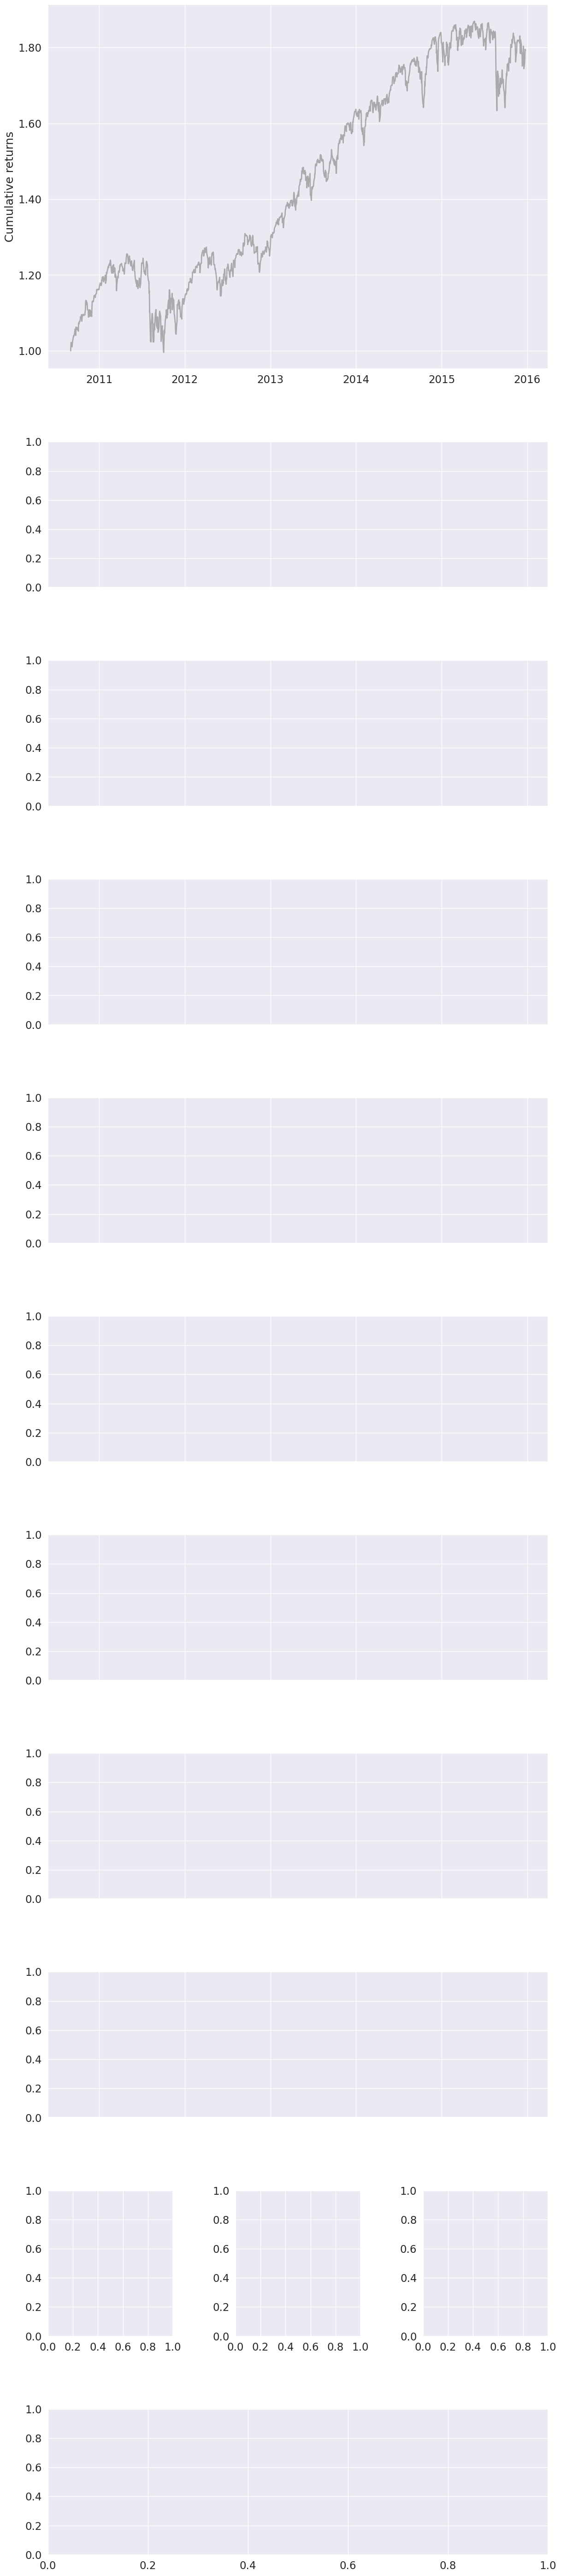

In [65]:
py.create_full_tear_sheet(stock_data['Portfolio_Value_rets'], benchmark_rets = benchmark_data['benchmark_rets'], live_start_date = live_date)

In [ ]:
# Calculate log returns
log_returns = np.log(stock_data / stock_data.shift(1))
log_returns = log_returns.dropna()

In [ ]:
import scipy.stats as stats
import seaborn as sns 
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, axes = plt.subplots(nrows=len(stock_data), ncols=2, figsize=(14, 3*len(stock_data)))

# Iterate over each stock to plot histogram and Q-Q plot
for i, stock in enumerate(stock_data):
    # Histogram
    sns.histplot(log_returns[stock], bins=100, kde=True, ax=axes[i, 0], color='gray')
    axes[i, 0].set_title(f'Histogram of {stock} Log Returns')
    axes[i, 0].set_xlabel('Log Return')
    axes[i, 0].set_ylabel('Frequency')
    
    # Q-Q plot
    stats.probplot(log_returns[stock], dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'Q-Q Plot of {stock} Log Returns')

plt.tight_layout()
plt.show()



ValueError: Image size of 1400x527400 pixels is too large. It must be less than 2^16 in each direction.

Error in callback <function _draw_all_if_interactive at 0x1245faef0> (for post_execute):


ValueError: Image size of 1400x527400 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1400x527400 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1400x527400 with 3516 Axes>